In [57]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers, models, callbacks
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import root_mean_squared_error, r2_score, mean_absolute_error

In [58]:
df = pd.read_csv("/Users/ayush/Documents/University/Year 03/Sem 01/DATA3888/Optiver-07/Data/individual_book_train/stock_0.csv")

In [59]:
def make_features(df: pd.DataFrame) -> pd.DataFrame:

    df = df.copy()

    df['mid_price'] = (df['bid_price1'] + df['ask_price1']) / 2

    df['log_return'] = (
        df.groupby('time_id')['mid_price']
          .transform(lambda x: np.log(x / x.shift(1)))
    )

    df['realized_volatility'] = (
        df.groupby('time_id')['log_return']
        .transform(lambda x: np.sqrt(
            ((x.shift(1) ** 2)
                .rolling(30, min_periods=1)
                .sum()
            ).clip(lower=0)
        ))
    )

    df['rv_future'] = (
        df.groupby('time_id')['realized_volatility'].shift(-30)   
    )

    df = df.dropna()   
    df = df.replace([np.inf, -np.inf], np.nan)
    return df

In [60]:
df = make_features(df)

In [61]:
id_cols        = ['time_id', 'stock_id']
feature_cols   = [
    'seconds_in_bucket',
    'bid_price1','ask_price1',
    'bid_price2','ask_price2',
    'bid_size1','ask_size1',
    'bid_size2','ask_size2',
    'mid_price','log_return','realized_volatility'
]
target_col     = 'rv_future'

In [62]:
unique_sessions  = np.sort(df['time_id'].unique())
split_idx        = int(len(unique_sessions) * 0.8)
train_val_ids    = unique_sessions[:split_idx]
test_ids         = unique_sessions[split_idx:]

train_val_df = df[df['time_id'].isin(train_val_ids)].copy()
test_df      = df[df['time_id'].isin(test_ids)].copy()

In [ ]:
x_scaler = MinMaxScaler().fit(train_val_df[feature_cols])
y_scaler = MinMaxScaler().fit(train_val_df[[target_col]])

for _df in (train_val_df, test_df):
    _df[feature_cols] = x_scaler.transform(_df[feature_cols])
    _df[target_col]   = y_scaler.transform(_df[[target_col]])

In [64]:
val_cut      = int(len(train_val_ids) * 0.9)
train_ids    = train_val_ids[:val_cut]
val_ids      = train_val_ids[val_cut:]

train_df = train_val_df[train_val_df['time_id'].isin(train_ids)]
val_df   = train_val_df[train_val_df['time_id'].isin(val_ids)]

In [65]:
SEQ_LEN = 30

In [ ]:
# Unique
def build_sequences(df_part: pd.DataFrame,
                    feature_cols: list[str],
                    target_col: str,
                    seq_len: int):
    X, y = [], []
    for _, session in df_part.groupby("time_id"):
        data   = session[feature_cols].values
        target = session[target_col].values
        for i in range(len(session) - seq_len):
            X.append(data[i : i + seq_len])
            y.append(target[i + seq_len])
    return np.asarray(X, dtype=np.float32), np.asarray(y, dtype=np.float32)

X_train, y_train = build_sequences(train_df, feature_cols, target_col, SEQ_LEN)
X_val,   y_val   = build_sequences(val_df,   feature_cols, target_col, SEQ_LEN)
X_test,  y_test  = build_sequences(test_df,  feature_cols, target_col, SEQ_LEN)

In [68]:
def build_baseline_hav_model(seq_len: int, n_features: int):
    inputs = layers.Input(shape=(seq_len, n_features))

    x = layers.Conv1D(16, kernel_size=3, activation='relu', padding='same')(inputs)
    x = layers.MaxPooling1D(pool_size=2)(x)

    attn_out = layers.MultiHeadAttention(num_heads=2, key_dim=x.shape[-1])(x, x)
    x = layers.Add()([x, attn_out])
    x = layers.LayerNormalization()(x)

    x = layers.GlobalAveragePooling1D()(x)
    outputs = layers.Dense(1, activation='linear')(x)
    return models.Model(inputs, outputs, name="HAV_baseline")

In [69]:
hav_baseline = build_baseline_hav_model(SEQ_LEN, X_train.shape[-1])
hav_baseline.compile(optimizer='adam', loss='mse')

In [73]:
early_stop = callbacks.EarlyStopping(monitor='val_loss',patience=5, restore_best_weights=True)
history = hav_baseline.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),     
    epochs=10,
    batch_size=32,
    shuffle=False,                      
    callbacks=[early_stop],
    verbose=1
)

Epoch 1/10
15369/15369 ━━━━━━━━━━━━━━━━━━━━ 19s 1ms/step - loss: 0.0013 - val_loss: 0.0010
Epoch 2/10
15369/15369 ━━━━━━━━━━━━━━━━━━━━ 19s 1ms/step - loss: 0.0013 - val_loss: 0.0010
Epoch 3/10
15369/15369 ━━━━━━━━━━━━━━━━━━━━ 19s 1ms/step - loss: 0.0013 - val_loss: 0.0010
Epoch 4/10
15369/15369 ━━━━━━━━━━━━━━━━━━━━ 19s 1ms/step - loss: 0.0013 - val_loss: 0.0010
Epoch 5/10
15369/15369 ━━━━━━━━━━━━━━━━━━━━ 19s 1ms/step - loss: 0.0013 - val_loss: 0.0010
Epoch 6/10
15369/15369 ━━━━━━━━━━━━━━━━━━━━ 19s 1ms/step - loss: 0.0013 - val_loss: 0.0010
Epoch 7/10
15369/15369 ━━━━━━━━━━━━━━━━━━━━ 19s 1ms/step - loss: 0.0013 - val_loss: 0.0010
Epoch 8/10
15369/15369 ━━━━━━━━━━━━━━━━━━━━ 19s 1ms/step - loss: 0.0013 - val_loss: 0.0010
Epoch 9/10
15369/15369 ━━━━━━━━━━━━━━━━━━━━ 19s 1ms/step - loss: 0.0013 - val_loss: 0.0010
Epoch 10/10
15369/15369 ━━━━━━━━━━━━━━━━━━━━ 19s 1ms/step - loss: 0.0013 - val_loss: 0.0010


In [74]:
y_pred_log    = hav_baseline.predict(X_test).flatten()
y_true_log    = y_test  

y_pred_log    = y_scaler.inverse_transform(y_pred_log .reshape(-1,1)).flatten()
y_true_log    = y_scaler.inverse_transform(y_true_log.reshape(-1,1)).flatten()

y_pred_raw = np.expm1(y_pred_log)
y_true_raw = np.expm1(y_true_log)

4192/4192 ━━━━━━━━━━━━━━━━━━━━ 2s 482us/step


In [75]:
rmse = root_mean_squared_error(y_true_log, y_pred_log)
r2   = r2_score(y_true_log, y_pred_log)
mae = mean_absolute_error(y_true_log, y_pred_log)

def qlike_safe(actual, forecast, eps=1e-8):
    a = np.clip(actual,   eps, None)
    f = np.clip(forecast, eps, None)
    r = a / f
    return np.mean(r - np.log(r) - 1.0)

ql = qlike_safe(y_true_log, y_pred_log)

print(f"Out‑of‑sample RMSE : {rmse:.6f}")
print(f"R² score           : {r2:.6f}")
print(f"QLIKE              : {ql:.6f}")
print(f"MAE:               : {mae:.6f}")

Out‑of‑sample RMSE : 0.000487
R² score           : 0.450318
QLIKE              : 0.149916
MAE:               : 0.000327


In [76]:
rmse = root_mean_squared_error(y_true_raw, y_pred_raw)
r2   = r2_score(y_true_raw, y_pred_raw)
mae = mean_absolute_error(y_true_raw, y_pred_raw)

def qlike_safe(actual, forecast, eps=1e-8):
    a = np.clip(actual,   eps, None)
    f = np.clip(forecast, eps, None)
    r = a / f
    return np.mean(r - np.log(r) - 1.0)

ql = qlike_safe(y_true_raw, y_pred_raw)

print(f"Out‑of‑sample RMSE : {rmse:.6f}")
print(f"R² score           : {r2:.6f}")
print(f"QLIKE              : {ql:.6f}")
print(f"MAE:               : {mae:.6f}")

Out‑of‑sample RMSE : 0.000488
R² score           : 0.450223
QLIKE              : 0.150014
MAE:               : 0.000328


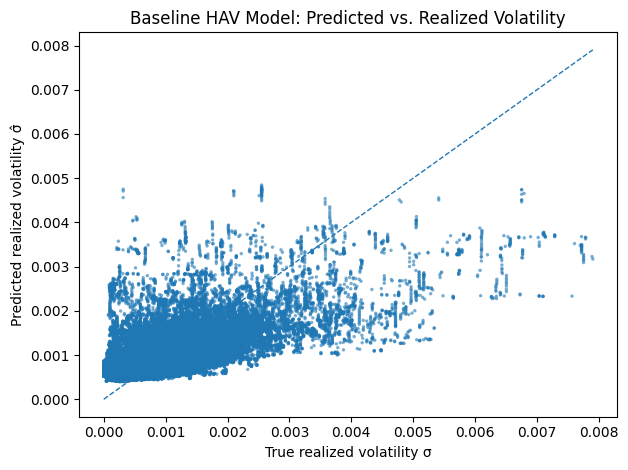

In [20]:
plt.figure()
plt.scatter(y_true_raw, y_pred_raw, s=6, alpha=0.6, edgecolor="none")
max_val = max(y_true_raw.max(), y_pred_raw.max())
plt.plot([0, max_val], [0, max_val], "--", linewidth=1)
plt.title("Baseline HAV Model: Predicted vs. Realized Volatility")
plt.xlabel("True realized volatility σ")
plt.ylabel("Predicted realized volatility σ̂")
plt.tight_layout()
plt.show()

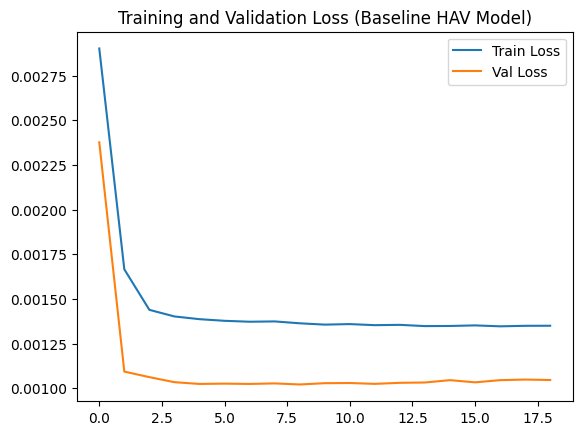

In [21]:
plt.figure()
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title("Training and Validation Loss (Baseline HAV Model)")
plt.legend()
plt.show()